In [5]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

kb = 8.61733262e-5 #Boltzmann constant in ev K^{-1}

recallable definitions for calculations of multiple runs

In [6]:
def param_calc(t9_0,rho_0,lambda_decay_0,lambda_excite_0,kb,den_frac,t,flag,energy):
    if (flag == 'constant'):
        t9 = t9_0*np.ones(len(t))
        lambda_decay = lambda_decay_0*np.ones(len(t))
        lambda_excite = lambda_excite_0*np.ones(len(t))
        rho = rho_0*np.ones(len(t))
    elif (flag == 'sinusoidal'):
        t9 = t9_0*(1 - t9_0*np.sin(2*np.pi*t/10))
        rho = den_frac*rho_0*np.power(t9,3)
        lambda_decay = lambda_decay_0*np.exp(-energy/(kb*t9*1e+9))
        lambda_excite = lambda_excite_0*np.exp(-energy/(kb*t9*1e+9))
    return t9,rho,lambda_decay,lambda_excite

def f1(y_85_m_dt,y_85_g_dt,y_85_m,dt,lambda_dec,lambda_ex):
    return y_85_m_dt*(1+lambda_dec*dt) - dt*lambda_ex*y_85_g_dt - y_85_m
    
def f2(y_85_m_dt,y_85_g_dt,y_85_g,dt,lambda_dec,lambda_ex):
    return y_85_g_dt*(1+dt*lambda_ex) - dt*lambda_dec*y_85_m_dt-y_85_g

def nef_raf_solver(lbda_ex,lbda_dec,t,y1,y2,y1_dt,y2_dt,y11,y22,tol):
    dt = t[1] - t[0]
    n_tot = len(t)
    for i in range(1,n_tot):
        delta = np.ones(2)
        A = np.array([[1 + lbda_dec[i]*dt, -dt*lbda_ex[i] ],[-lbda_dec[i]*dt, 1 + lbda_ex[i]]])
        while (abs(max(delta)) > tol):
            b = np.array([-f1(y1_dt,y2_dt,y1,dt,lbda_dec[i],lbda_ex[i]),
            -f2(y1_dt,y2_dt,y2,dt,lbda_dec[i],lbda_ex[i])])
            delta = np.linalg.solve(A,b)
            y1_dt += delta[0]
            y2_dt += delta[0]
        y1 = y1_dt
        y2 = y2_dt
        
        y11 = np.append(y11,y1)
        y22 = np.append(y22,y2)

    return y11,y22

Cell of parameters that govern the whole run

In [7]:
tol = 1e-6
t9_0 = 0.2
rho_0 = 1e+3 #g/cc
den_frac = 0.5
flag = 'constant'
lambda_decay_0 = 0.001
lambda_excite_0 = 0.001
energy = 0
t = np.linspace(0,100,1000)

t9,rho,lambda_decay,lambda_excite = param_calc(t9_0,rho_0,lambda_decay_0,lambda_excite_0,kb,den_frac,t,flag,energy)

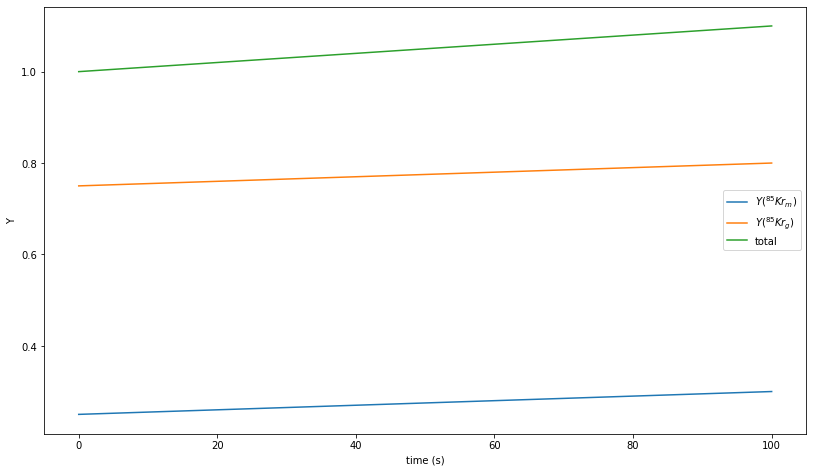

In [8]:
#at time 0
y_kr85_m = 0.25
y_kr85_g = 0.75
#initial guess
y_kr85_m_dt = y_kr85_m
y_kr85_g_dt = y_kr85_g

y_kr85_m,y_kr85_g = nef_raf_solver(lambda_excite,lambda_decay,t,y_kr85_m,y_kr85_g,y_kr85_m,y_kr85_g,y_kr85_m,y_kr85_g,tol)

plt.figure(figsize=[13.66,7.86])
plt.plot(t,y_kr85_m,label = r'$Y(^{85}Kr_{m})$')
plt.plot(t,y_kr85_g,label = r'$Y(^{85}Kr_{g})$')
plt.plot(t,y_kr85_g+y_kr85_m, label = 'total')
plt.ylabel('Y')
plt.xlabel('time (s)')
plt.legend()
plt.show()